*TEAM 1*

1992370 Hannia Medina Aguilar 

1849023 Ricardo Diaz Renteria

1895594 Marina Fernanda Lopez Gonzalez

1897293 Ana Gabriela Perez Hernandez

1910931 Marlene Grimaldo Paez

1992022 Jesus Miguel Valenzuela Ponce

---

# Final Project:
# **Convolutional Neural Network training**
Course: Artificial Intelligence

---


# Introduction

In this project we trained a CNN to classified the images from the [Chest CT-Scan images Dataset](https://www.kaggle.com/datasets/mohamedhanyyy/chest-ctscan-images)


---
# Access to Drive
First, access to data in Google Drive was enabled

In [1]:
# Mounting Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



---
# Libraries
Then, the necessary libraries were imported

In [2]:
# Importing libraries
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


---
# **Preprocessing**
The dataset consist in 1000 CT-scan images, it was splitted randomly in train, validation and test, in 70%, 10%, and 20%, respectively.



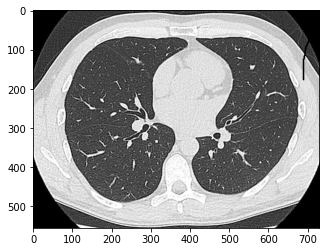

In [ ]:
# Visualizing test image
path_im = '/content/drive/My Drive/archive/normal/7 - Copy (2)_.png'
test_im = cv2.imread(path_im, cv2.IMREAD_GRAYSCALE)
plt.imshow(test_im, cmap='gray')

In [ ]:
pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Importing library to split from folders
import splitfolders

splitfolders.ratio('/content/drive/My Drive/archive/', # Original dataset folder
                   output='/content/drive/My Drive/Dataset/', # Splitted dataset new folder
                   seed=42, # State of random generator
                   ratio=(0.70, 0.10, 0.20), # The ratio of splited dataset in train, val, test
                   group_prefix=None, # Only one format
                   )

Copying files: 1000 files [00:07, 129.36 files/s]


In [3]:
# Defining paths
train_path = '/content/drive/My Drive/Dataset/train'
val_path = '/content/drive/My Drive/Dataset/val'
test_path = '/content/drive/My Drive/Dataset/test'

In [4]:
# Showing the amount of images in each sub dataset
def GetDatasetSize(path):
    num_of_image = {}
    for folder in os.listdir(path):
        # Counting the Number of Files in the Folder
        num_of_image[folder] = len(os.listdir(os.path.join(path, folder)));
    return num_of_image;
    
train_set = GetDatasetSize(train_path)
val_set = GetDatasetSize(val_path)
test_set = GetDatasetSize(test_path)
print('Train set', train_set,'\n','Validation set',val_set,'\n','Test set', test_set)

Train set {'adenocarcinoma': 236, 'squamous.cell.carcinoma': 182, 'normal': 150, 'large.cell.carcinoma': 130} 
 Validation set {'adenocarcinoma': 33, 'squamous.cell.carcinoma': 26, 'normal': 21, 'large.cell.carcinoma': 18} 
 Test set {'adenocarcinoma': 69, 'squamous.cell.carcinoma': 52, 'normal': 44, 'large.cell.carcinoma': 39}


The function ImageDataGenerator was implemented to rescale the images, and also to applied Data Augmentation in the train subset.

The function flow_from_directory was implemented to resize the images to 256x256 px.

In [ ]:
# Data augmentation, rescaling and resizing of train data
train_data_augmentation = ImageDataGenerator(rescale = 1.0/255.0,
                                             horizontal_flip = True,
                                             fill_mode = 'nearest',
                                             zoom_range = 0.2,
                                             shear_range = 0.2,
                                             width_shift_range = 0.2,
                                             height_shift_range = 0.2,
                                             rotation_range=0.4)

train_data = train_data_augmentation.flow_from_directory(train_path, 
                                                         batch_size = 5,
                                                         target_size = (256,256),
                                                         class_mode = 'categorical')

Found 698 images belonging to 4 classes.


In [ ]:
# Rescaling and resizing of validation data
val_data_gen = ImageDataGenerator(rescale = 1.0/255.0)
val_data = val_data_gen.flow_from_directory(val_path,
                                            batch_size = 5,
                                            target_size = (256,256),
                                            class_mode = 'categorical')

Found 98 images belonging to 4 classes.


In [5]:
# Rescaling and resizing of test data
test_data_gen = ImageDataGenerator(rescale = 1.0/255.0)
test_data = test_data_gen.flow_from_directory(test_path,
                                              batch_size = 5,
                                              target_size = (256,256),
                                              class_mode = 'categorical')

Found 204 images belonging to 4 classes.


In [ ]:
# Visualizing training labels
train_data.class_indices

{'adenocarcinoma': 0,
 'large.cell.carcinoma': 1,
 'normal': 2,
 'squamous.cell.carcinoma': 3}

In [6]:
# Saving class names
class_names = ['adenocarcinoma','large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma', ]


---
# **CNN architecture and training**
The Convolutional Neural Network was based in transfer learning. 

The InceptionResNetV2 architecture provided by Keras was implemented as the backbone of the CNN.

In [ ]:
# Importing the InceptionResNetV2 pre-trained CNN from Keras
from tensorflow.keras.applications import InceptionResNetV2

# Defining the pre-trained model
pretrained_model = InceptionResNetV2( include_top = False, # Do not include layer at the top of the network
                                      weights = "imagenet", # Loading pretrained weights
                                      input_shape = (256,256,3),
)

# Setting the pre-trained model to non-trainable layers
for layer in pretrained_model.layers:
  layer.trainable = False

In [ ]:
model = Sequential()

# Adding the pre-trained model
model.add(pretrained_model)

# Classification section
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(4, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 6, 6, 1536)       54336736  
 onal)                                                           
                                                                 
 flatten (Flatten)           (None, 55296)             0         
                                                                 
 dense (Dense)               (None, 1024)              56624128  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 4)                 4100      
                                                                 
Total params: 110,964,964
Trainable params: 56,628,228
Non-trainable params: 54,336,736
__________________________________

In [ ]:
# Compiling the complete model
model.compile(optimizer= tf.keras.optimizers.RMSprop(learning_rate = 0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Adding Model check point Callback
check_point = ModelCheckpoint(
    filepath= '/content/drive/My Drive/best_model_CNN.hdf5',
    monitor= 'val_accuracy', 
    verbose= 1,
    save_best_only= True, 
    mode = 'max'
    );

In [ ]:
# Adding Early Stopping Callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.01,
    patience=25,
    verbose=1,
    mode='max',
    restore_best_weights=False,
)

In [ ]:
# Training of the CNN
history = model.fit(
    train_data, 
    steps_per_epoch = train_data.samples//train_data.batch_size, 
    epochs = 100, 
    validation_data = val_data, 
    validation_steps = val_data.samples//val_data.batch_size,
    callbacks = [ check_point, early_stopping ]
    )


Epoch 1/100
139/139 [==============================] - ETA: 0s - loss: 6.5772 - accuracy: 0.3867
Epoch 1: val_accuracy improved from -inf to 0.66316, saving model to /content/drive/My Drive/best_model_CNN.hdf5
139/139 [==============================] - 35s 151ms/step - loss: 6.5772 - accuracy: 0.3867 - val_loss: 1.4108 - val_accuracy: 0.6632
Epoch 2/100
139/139 [==============================] - ETA: 0s - loss: 2.1609 - accuracy: 0.5209
Epoch 2: val_accuracy did not improve from 0.66316
139/139 [==============================] - 15s 109ms/step - loss: 2.1609 - accuracy: 0.5209 - val_loss: 0.7946 - val_accuracy: 0.6526
Epoch 3/100
139/139 [==============================] - ETA: 0s - loss: 1.4328 - accuracy: 0.5527
Epoch 3: val_accuracy did not improve from 0.66316
139/139 [==============================] - 14s 104ms/step - loss: 1.4328 - accuracy: 0.5527 - val_loss: 0.8921 - val_accuracy: 0.6526
Epoch 4/100
139/139 [==============================] - ETA: 0s - loss: 1.2839 - accuracy: 0.

In [ ]:
# Saving model
model.save('/content/drive/My Drive/CNN_model.h5')

---
# **Results**
The model was evaluated with the test data, obtaining an accuracy of 88.24%, as seen in the graph below.

In [15]:
model = load_model('/content/drive/My Drive/CNN_model.h5')

In [16]:
# Evaluation
test_loss, test_acc = model.evaluate(test_data)

41/41 [==============================] - 77s 2s/step - loss: 0.6006 - accuracy: 0.9167


In [17]:
print('Test accuracy: ',test_acc, '\nTest loss: ', test_loss)

Test accuracy:  0.9166666865348816 
Test loss:  0.6005770564079285


Text(0.5, 1.0, 'Training vs validation accuracy')

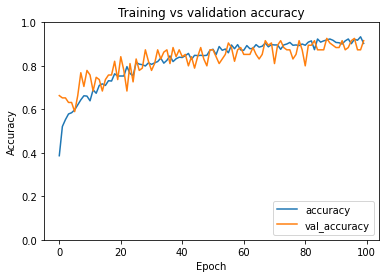

In [ ]:
# Plotting of the training accuracy vs validation accuracy during training
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.legend(loc = 'lower right')
plt.title("Training vs validation accuracy")

Text(0.5, 1.0, 'Training vs validation loss')

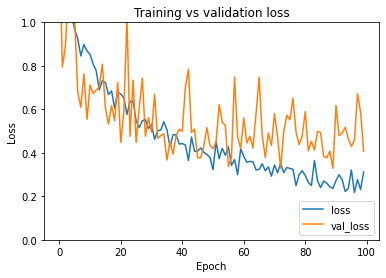

In [ ]:
# Plotting of the training loss vs validation loss during training
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0,1])
plt.legend(loc = 'lower right')
plt.title("Training vs validation loss")

In [18]:
# Loading model at best checkpoint
model_best = load_model('/content/drive/My Drive/best_model_CNN.hdf5')
test_loss, test_acc = model_best.evaluate(test_data)

41/41 [==============================] - 74s 2s/step - loss: 0.7269 - accuracy: 0.8627


# **Predictions**
Predictions with the trained CNN

In [19]:
model = load_model('/content/drive/My Drive/CNN_model.h5')

The activation function of the output layer is Softmax, so the outputs or predictions are in form of probabilities. A function was defined to return the name class according to the class with the highest probability.

In [20]:
def prediction_fn(path, _model):
    classes_dir = class_names
    # Loading Image
    img = image.load_img(path, target_size=(256,256))
    # Normalizing Image
    norm_img = image.img_to_array(img)/255
    # Converting Image to Numpy Array
    input_arr_img = np.array([norm_img])
    # Getting Predictions
    pred = np.argmax(_model.predict(input_arr_img))
    # Printing Model Prediction
    return classes_dir[pred]

Random arrays containing 3 image paths for each of the 4 possible classes were randomly created.

In [21]:
np.random.seed(3)

# Random images from large.cell.carcinoma
largecell_vector = []
for i in range(3):
  path_largecell = test_path+'/large.cell.carcinoma/'
  random_im = np.random.choice(os.listdir(path_largecell))
  largecell_vector.append(path_largecell+random_im)

# Random images from adenocarcinoma
adeno_vector = []
for i in range(3):
  path_adeno = test_path+'/adenocarcinoma/'
  random_im = np.random.choice(os.listdir(path_adeno))
  adeno_vector.append(path_adeno+random_im)

# Random images from large.cell.carcinoma
normal_vector = []
for i in range(3):
  path_normal = test_path+'/normal/'
  random_im = np.random.choice(os.listdir(path_normal))
  normal_vector.append(path_normal+random_im)

# Random images from large.cell.carcinoma
sq_vector = []
for i in range(3):
  path_sq = test_path+'/squamous.cell.carcinoma/'
  random_im = np.random.choice(os.listdir(path_sq))
  sq_vector.append(path_sq+random_im)

The 12 predictions are shown below

In [22]:
for i in normal_vector:
  true = prediction_fn(i,model)
  print("Prediction of",i, "\nThe CNN predicts",true,"\nAnd in reality is normal\n")

for i in largecell_vector:
  true = prediction_fn(i,model)
  print("Prediction of",i, "\nThe CNN predicts",true,"\nAnd in reality is large.cell.carcinoa\n")

for i in sq_vector:
  true = prediction_fn(i,model)
  print("Prediction of",i, "\nThe CNN predicts",true,"\nAnd in reality is squamous.cell.carcinoma\n")

for i in adeno_vector:
  true = prediction_fn(i,model)
  print("Prediction of",i, "\nThe CNN predicts",true,"\nAnd in reality is adenocarcinoma\n")

1/1 [==============================] - 5s 5s/step
Prediction of /content/drive/My Drive/Dataset/test/normal/6 - Copy (2)-.png 
The CNN predicts normal 
And in reality is normal

1/1 [==============================] - 0s 423ms/step
Prediction of /content/drive/My Drive/Dataset/test/normal/7 (2)-.png 
The CNN predicts normal 
And in reality is normal

1/1 [==============================] - 0s 433ms/step
Prediction of /content/drive/My Drive/Dataset/test/normal/10 (2).png 
The CNN predicts normal 
And in reality is normal

1/1 [==============================] - 0s 395ms/step
Prediction of /content/drive/My Drive/Dataset/test/large.cell.carcinoma/000016 (3).png 
The CNN predicts large.cell.carcinoma 
And in reality is large.cell.carcinoa

1/1 [==============================] - 0s 396ms/step
Prediction of /content/drive/My Drive/Dataset/test/large.cell.carcinoma/000169.png 
The CNN predicts large.cell.carcinoma 
And in reality is large.cell.carcinoa

1/1 [==============================] - 0


---

### ***R E F E R E N C E S***
GeeksforGeeks. (2019, December 29). Understanding for-loop in Python. Retrieved September 14, 2022, from https://www.geeksforgeeks.org/understanding-for-loop-in-python/

López, D. (2022, September 13). Python. GitHub. Retrieved September 14, 2022, from https://github.com/dilp90/InteligenciaArtificial_y_RedesNeuronales_UANL_FIME/tree/main/Python
